In [22]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [13]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

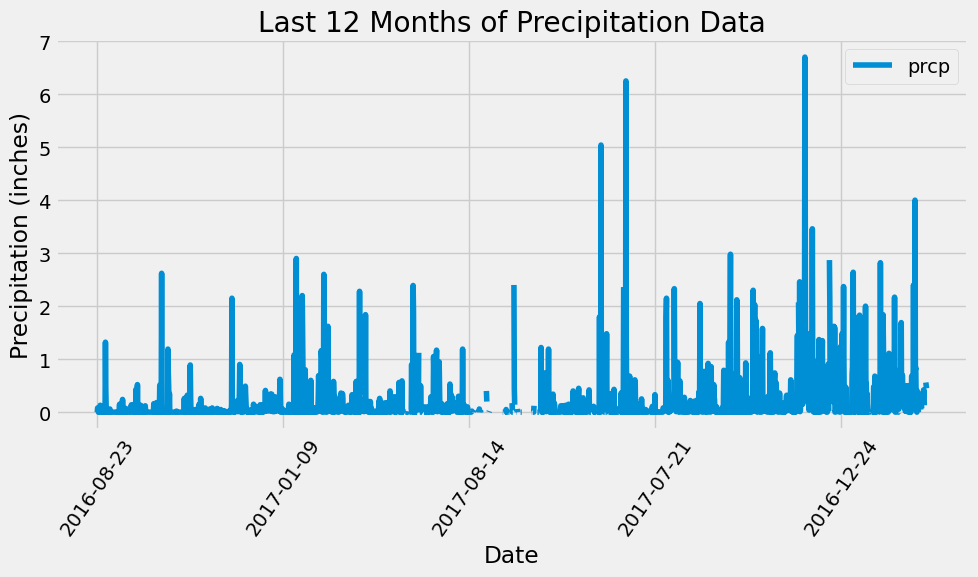

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date
# Calculate the date one year from the last date in data set.
date_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data_prcp = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= date_year_ago).\
    filter(measurement.date <= dt.date(2017, 8, 23)).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(data_prcp, columns=['date', "prcp"])
df.set_index('date', inplace = True)

# Sort the dataframe by date
df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(10, 6))
plt.title('Last 12 Months of Precipitation Data')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=55)
plt.tight_layout()
plt.show()

In [30]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [31]:
# Design a query to calculate the total number of stations in the dataset
total_station = session.query(measurement.station).distinct().count()
total_station

9

In [34]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station)).\
                        group_by(measurement.station).\
                        order_by(func.count(measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [52]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperatures_station = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()
temperatures_station

[(54.0, 85.0, 71.66378066378067)]

In [55]:
# Find the most recent date in the data set for the most active station id
date_station = session.query(measurement.date).\
    filter(measurement.station == 'USC00519281').\
        order_by(measurement.date.desc()).first()
date_station

('2017-08-18',)

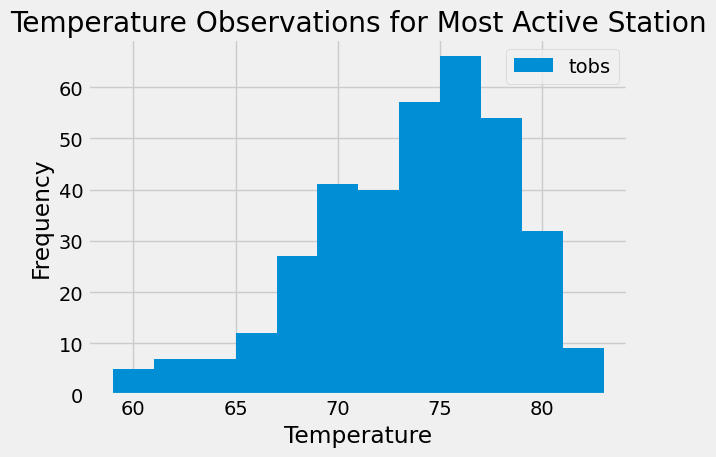

In [58]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
date_year_ago_station = dt.date(2017, 8, 18) - dt.timedelta(days=365)

# Query the temperature observations for the most active station within the last 12 months
results = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(measurement.date >= date_year_ago_station).\
    filter(measurement.date <= dt.date(2017, 8, 18)).all()

# Convert the query results into a list
temperatures = [result[0] for result in results]

# Use Pandas Plotting with Matplotlib to plot the data
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Most Active Station')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()